# Gaussian processes

The theory discussion in this section is currently __very__ incomplete. Hopefully the implementation discussion will still be helpful however.

## A bit of background

Now that we've encountered a means for mathematically describing the similarity between data we need to develop some method to take this information and perform regression. 

Suppose every observation which we make is drawn from a normal distribution which has some mean value, and some standard deviation.

\\[ y \sim \mathcal{N}(\mu, \sigma) \\]

This means that if we have a whole set of data it will be drawn from a multivariate normal distribution: we'll have a collection of random variables. So for two data

\\[ (y_1, y_2) \sim \mathcal{N}(\vec{\mu}, \Sigma) \\]

where $\Sigma$ is the covariance matrix for the multivariate normal distribution. We can extend this continually to whatever size of data set we have.

We define $\Sigma$ as the covariance of the points $(x_1, x_2)$ where the data $(y_1, y_2)$ are observed, and we end up with a *Gaussian process prior*; for simplicity we normally take the mean to be zero (and this can be ensured by pre-processing our data).

In [4]:
%matplotlib inline

import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

## Example: Fitting a one-dimensional function

Let's return to the fitting problem from the previous chapter, and see how a Gaussian process performs on this data.

/home/daniel/.virtualenvs/IGRlaptop21/gp-tutorial/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


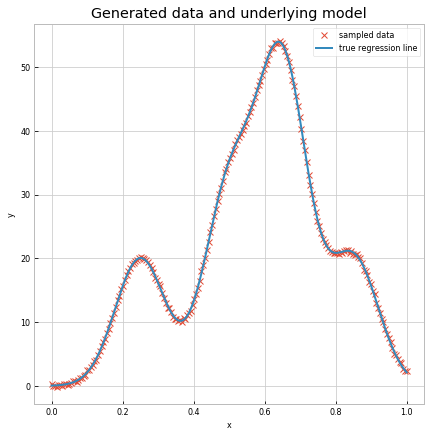

In [2]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x

def normal(x, mean, std):
    return np.exp(-(x-mean)**2/std**2)/std**2

true_regression_line = 0.3*normal(x,0.5,0.1) + 0.2*normal(x,0.25,0.1) + 0.2*normal(x,0.85,0.1) + 0.5*normal(x,0.65,0.1)
y = true_regression_line + np.random.normal(scale=.15, size=size)

data = dict(x=x, y=y)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

The `pymc3` implementation of the type of Gaussian process we need is called a "marginal likelihood" model. We need to specify our covariance function, and also a prior distribution on the noise in the signal.

In [12]:
with pm.Model() as model:
    # Specify the covariance function.
    cov_func = pm.gp.cov.ExpQuad(1, 0.1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # 
    sigma = pm.Normal("sigma", 0, 2)
    y_ = gp.marginal_likelihood("y", X=x[::,None], y=y, noise=sigma)

The slightly odd index `x[::,None]` converts `x` from a one-dimensional array to a two-dimensional one, as `pymc3` expects the data to be two dimensional.

Now that we have our model, we need to run an optimiser on it. For this model this will be very fast, since we've put most of the numbers in by hand.

In [13]:
with model:
    mp = pm.find_MAP()

logp = -2.2761e+06, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 52.95it/s]


With our "trained" model we can now have a look at the fitting function and the model's predictions for regions outwith the trained parameter space.

In [17]:
x_new = np.linspace(0,2, 200)[::,None]

In [ ]:
mu, var = gp.predict(x_new, point=mp, diag=True)
sd = np.sqrt(var)

The `gp.predict` method takes a new set of points to evaluate the mean function from the Gaussian process at, along with the variance at each of those points.

We can then plot the mean function and an error region around the mean.

/home/daniel/.virtualenvs/IGRlaptop21/gp-tutorial/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


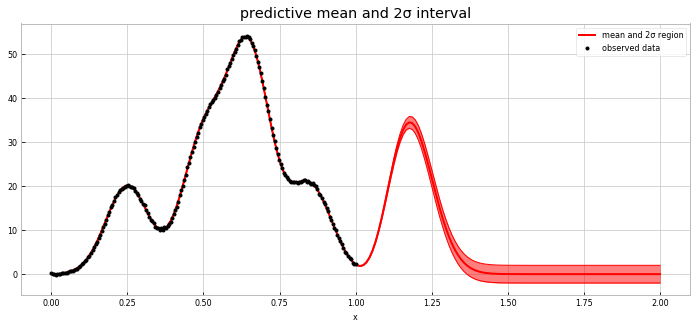

In [19]:
# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(x_new, mu, 'r', lw=2, label="mean and 2σ region");
plt.plot(x_new, mu + 2*sd, 'r', lw=1); plt.plot(x_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(x_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(x, y, 'ok', ms=3, alpha=1.0, label="observed data");
#plt.plot(x, f_true, "dodgerblue", lw=3, label="true f");

plt.xlabel("x");# plt.ylim([-13,13]);
plt.title("predictive mean and 2σ interval"); plt.legend();

We can see that the GP does a very good job of regression on the data, with the error region almost impossible to see. However, outside the trained area things get less clear, and the error region expands.

We can also look at the actual functions which can be drawn from the GP. `pymc3` does this with a method called `gp.conditional`, and again we specify the locations at which we want the functions to be evaluated.

In [21]:
with model:
    f_pred = gp.conditional("f_pred", x_new)

Then we can draw the samples from the GP.

In [22]:
with model:
    pred_samples = pm.sample_ppc([mp], vars=[f_pred], samples=2000)

100%|██████████| 2000/2000 [00:48<00:00, 41.26it/s]


/home/daniel/.virtualenvs/IGRlaptop21/gp-tutorial/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


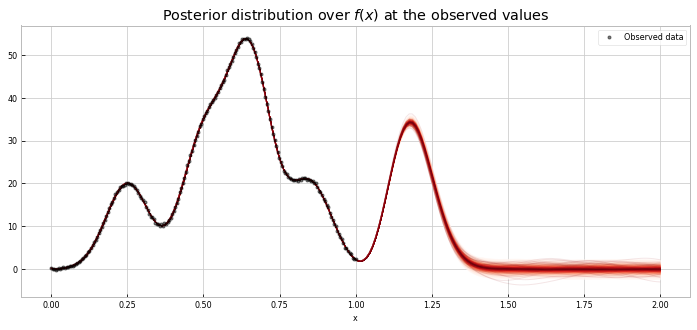

In [26]:
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], x_new);

plt.plot(x, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("x"); 
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();